# Project 2: Log Regression

Implement logistic regression with stochastic gradient descent as the optimization algorithm, with and without the L2 regularization penalty. 


Divide your data into roughly 80% train, 10% validation, 10% test as in the previous assignment and use the validation dataset to tune any parameters.


Replicate the analysis of the South African heart disease dataset from the Elements of Statistical Learning textbook and plot figure 4.12. Additionally, report the % correct for all 3 models (unregularized, stepwise, and L2 regularized) in a table. Instead of plotting the tables and dropping terms based on Z score, select the optimal model using forward stepwise via cross-testidation and report which features are the most important.


Repeat this analysis for a binary classification dataset of your choice from UCI or another repository.



Stretch goal #1 (3 points): Implement the L1 penalty as well, and produce a Lasso plot like figure 4.13. Include your results in the % correct table. Use the validation dataset to select the optimal lambda and determine the most important features. Do those features agree with the stepwise feature selection?


There are lots of ways to implement the L1 penalty,  several detailed in this paper:  https://www.aclweb.org/anthology/P09-1054.pdf


Stretch goal #2 (3 points): Extend your unregularized logistic regression to mutlinomial regression(i.e. more than binary classification). It is a pretty straightforward extension, but its not covered in elements of stats. You can google for derivations if you want, but mainly all you really need is to find the gradient of the loss function in the multinomial case. This is covered in section 4.3.4 of another classic ML text by Bishop( pdf here: https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf). The equation for the gradient is eqn 4.109. Test your approach on a simple M-ary classification dataset like the Iris dataset from UCI.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
heart_df = pd.read_csv('South African Heart Disease.txt')
heart_df = heart_df.drop(columns='row.names')
heart_df = heart_df.sample(n=len(heart_df))    # shuffle dataset!!!
heart_df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
172,124,0.00,4.79,34.71,Absent,49,26.09,9.26,47,0
141,130,2.78,4.89,9.39,Present,63,19.30,17.47,25,1
182,170,4.20,4.67,35.45,Present,50,27.14,7.92,60,1
368,126,3.40,4.87,15.16,Present,65,22.01,11.11,38,0
434,132,0.00,3.55,8.66,Present,61,18.50,3.87,16,0


In [3]:
# one-hot famhist
heart_df['famhist'] = pd.get_dummies(heart_df['famhist'])['Present']

## Scatterplot

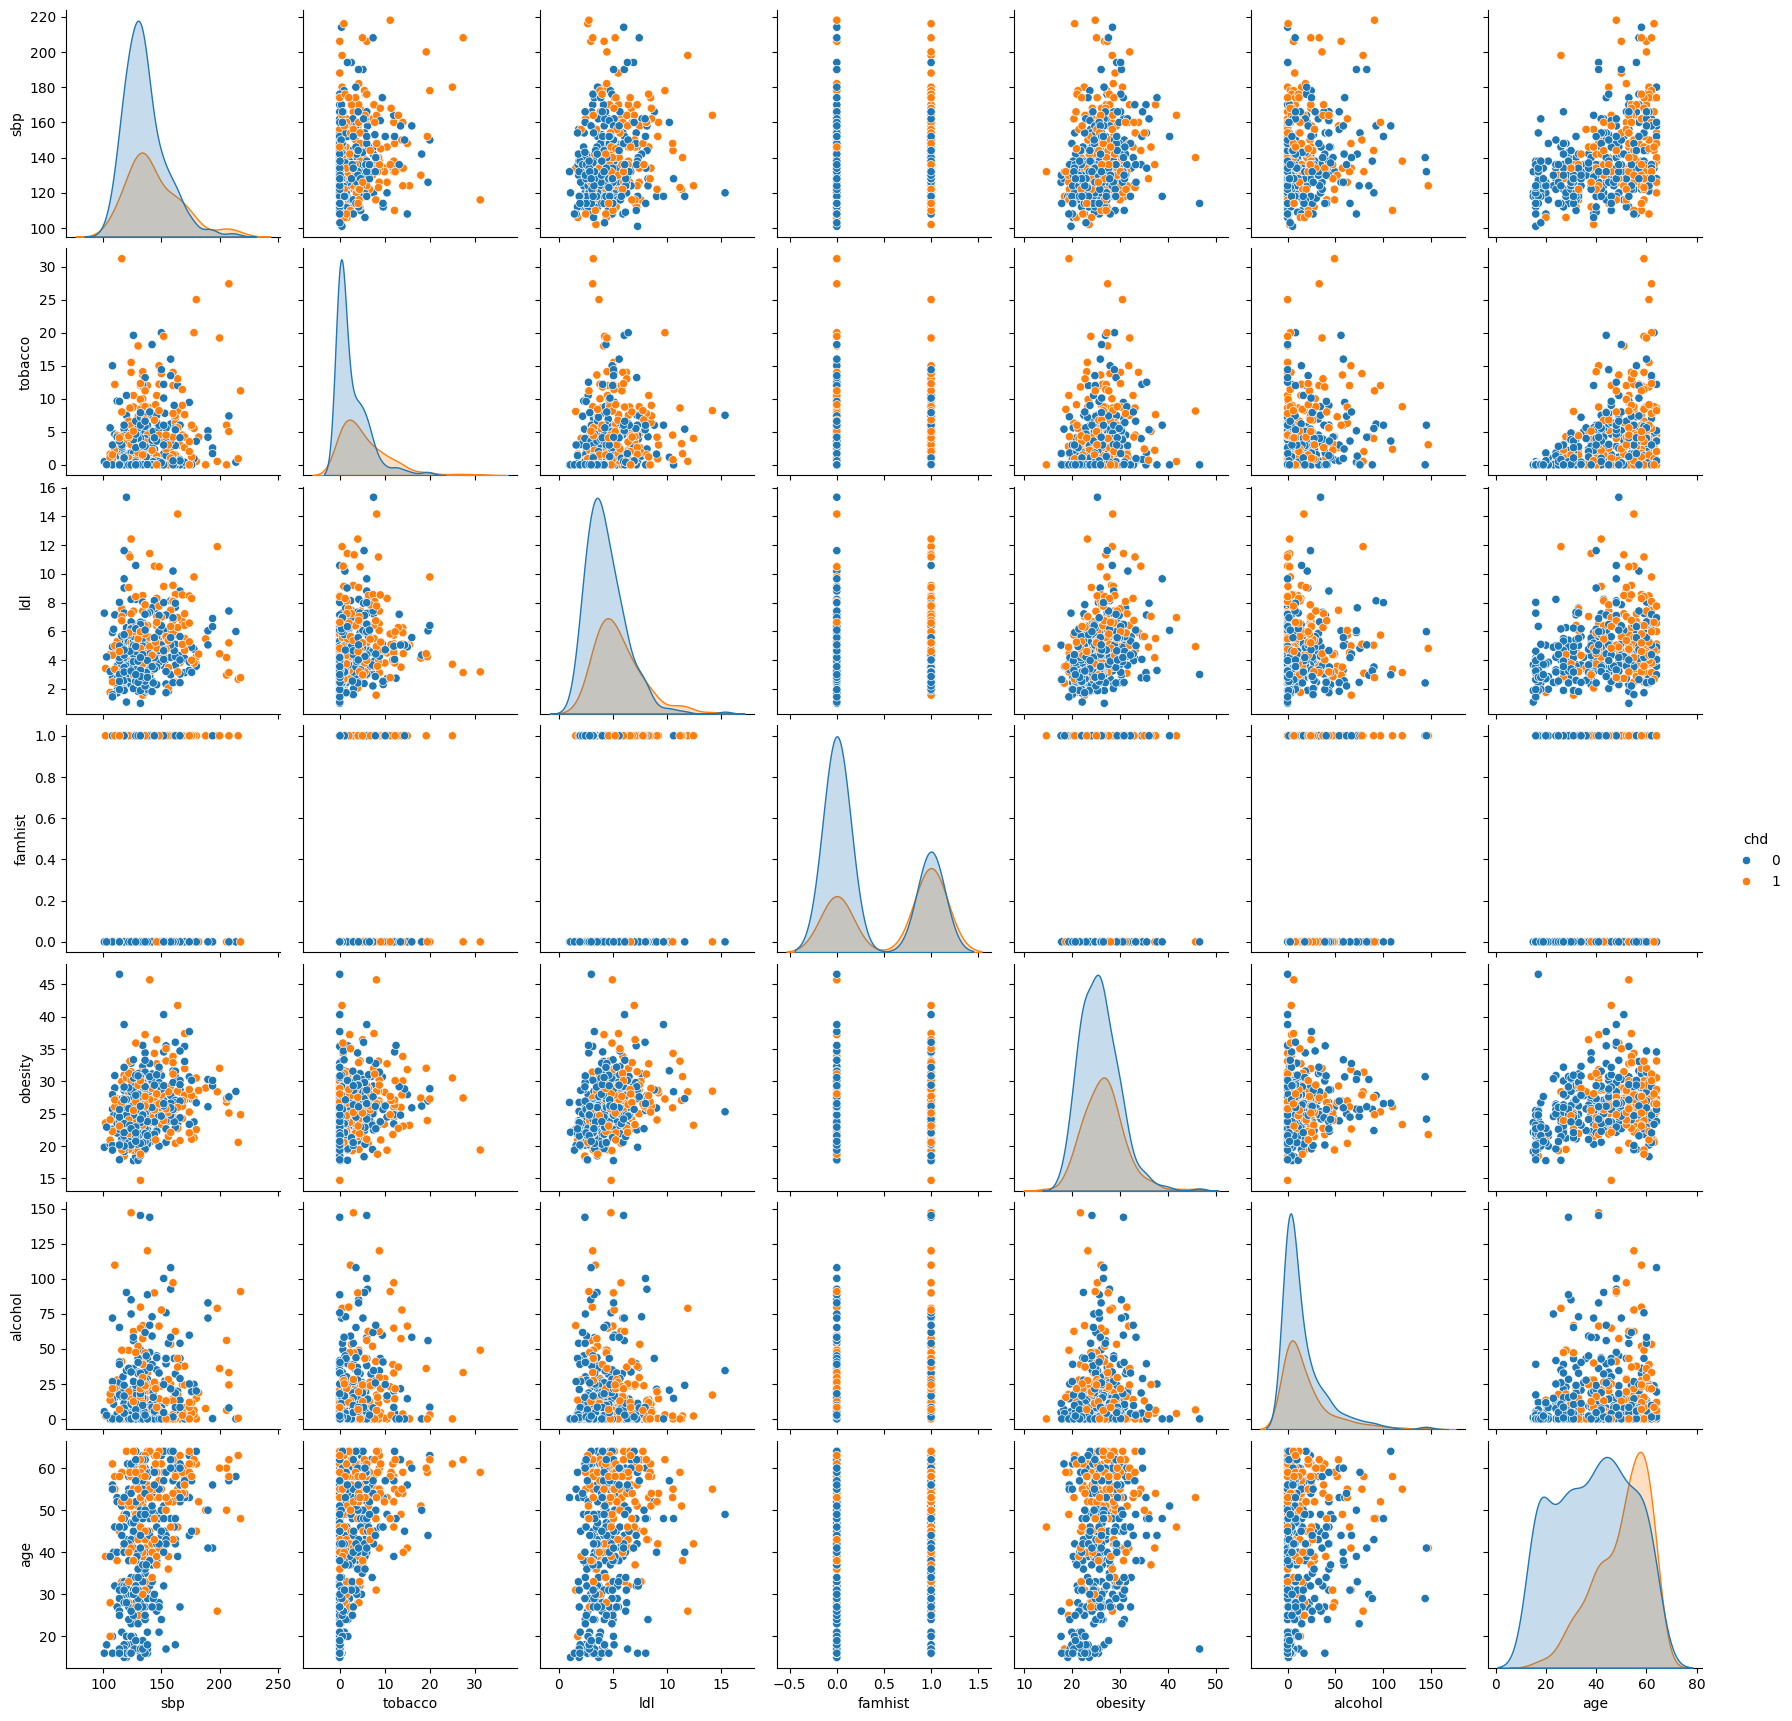

In [4]:
scatter_features = ['sbp','tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age', 'chd']
scatter_df = heart_df[scatter_features]
sns.pairplot(scatter_df, hue="chd")

## log reg

In [4]:
X = heart_df.drop(columns='chd')
y = heart_df['chd']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
X_test = pd.DataFrame(scaler.transform(X_test))

In [5]:
def sigmoid(x):
    x = np.array(x,dtype=np.float32)
    return 1 / (1 + np.exp(-x))

def compute_loss(y_t, y_p):
    # binary cross entropy
    sums = [] 
    for y_true, y_pred in zip(y_t, y_p):
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        sums.append(y1 + y2)
    return -np.mean(sums)

In [6]:
np.random.seed(42)

def logistic_regression_sgd(X, y, lr=0.01, epochs=100, reg_lambda=0.1, use_l2=False):
    n_obs, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 1
    X = X.to_numpy()
    y = y.to_numpy()


    for epoch in range(epochs):
        for i in range(n_obs):
            # Stochastic Gradient Descent
            idx = np.random.randint(0, n_obs)
            xi = X[idx]
            yi = y[idx]
            z = np.dot(xi, weights) + bias
            y_pred = sigmoid(z)

            # Calculate gradients
            error = yi - y_pred
            weights_gradient = error * xi
            bias_gradient = error

            # Update weights and bias
            if use_l2:
                weights += (lr * (weights_gradient - reg_lambda * weights)).astype(float)
            else:
                weights += (lr * weights_gradient).astype(float)
            bias += lr * bias_gradient

    return weights, bias


In [7]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def predict(X, weights, bias):
    linear_output = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_output)
    return [1 if i > 0.5 else 0 for i in y_pred]

In [116]:
weights_unreg, bias_unreg = logistic_regression_sgd(X_train, y_train, lr=0.1, epochs=1, use_l2=False)
y_train_pred_unreg = predict(X_train, weights_unreg, bias_unreg)
train_acc_unreg = accuracy_score(y_train, y_train_pred_unreg)

y_val_pred_unreg = predict(X_val, weights_unreg, bias_unreg)
val_acc_unreg = accuracy_score(y_val, y_val_pred_unreg)

print(f'(Unregularized) Train Acc: {train_acc_unreg}, Val Acc: {val_acc_unreg}')

(Unregularized) Train Acc: 0.7235772357723578, Val Acc: 0.8043478260869565


In [117]:
weights_reg, bias_reg = logistic_regression_sgd(X_train, y_train, lr=0.1, epochs=1, reg_lambda=0.02, use_l2=True)
y_train_pred_reg = predict(X_train, weights_reg, bias_reg)
train_acc_reg = accuracy_score(y_train, y_train_pred_reg)

y_val_pred_reg = predict(X_val, weights_reg, bias_reg)
val_acc_reg = accuracy_score(y_val, y_val_pred_reg)

print(f'(With L2 Regularization) Train Acc: {train_acc_reg}, Val Acc: {val_acc_reg}')

(With L2 Regularization) Train Acc: 0.7127371273712737, Val Acc: 0.6956521739130435


### Stepwise

In [118]:
def forward_selection(X, y):
    n_obs, n_features = X.shape
    remaining_features = list(range(n_features))
    selected_features = []
    best_model = None
    best_features = []
    best_acc = 0

    X_arr = X.to_numpy()
    y_arr = y.to_numpy()
    
    while remaining_features:
        best_current_feature = None
        for feature in remaining_features:
            selected_features.insert(0, feature)
            # print(selected_features)
            current_weights, current_bias = logistic_regression_sgd(X.iloc[:,np.unique(selected_features)], y, lr=0.1, epochs=1, use_l2=False)
            y_pred = predict(X.iloc[:, np.unique(selected_features)], current_weights, current_bias)
            accuracy = accuracy_score(y, y_pred)
            if accuracy > best_acc:
                best_acc = accuracy
                best_current_feature = feature
                best_model = (current_weights, current_bias)
                best_features = selected_features
            else:
                selected_features.remove(feature)
        if best_current_feature is not None:
            best_features.insert(0, best_current_feature)
            remaining_features.remove(best_current_feature)
        else:
            break
    
    print("best training accuracy: ", best_acc)
    return best_model, best_features, best_acc




In [119]:
(best_weights, best_bias), best_features, best_acc = forward_selection(X_train, y_train)

best training accuracy:  0.7371273712737128


In [120]:
y_val_pred_step = predict(X_val.iloc[:, np.unique(best_features)], best_weights, best_bias)
val_acc_step = accuracy_score(y_val, y_val_pred_step)
print(f'(Stepwise) Train Acc: {best_acc}, Val Acc: {val_acc_step}')

(Stepwise) Train Acc: 0.7371273712737128, Val Acc: 0.8478260869565217


In [121]:
np.sum(y == 0) / len(y) # bc there are more 0s in dataset, we will choose all 0s for baseline

np.float64(0.6536796536796536)

In [122]:
test_acc_baseline = accuracy_score(y_test, np.zeros(len(y_test)))
print(f'(Baseline)               Test Acc: {test_acc_baseline}')

y_test_pred_unreg = predict(X_test, weights_unreg, bias_unreg)
test_acc_unreg = accuracy_score(y_test, y_test_pred_unreg)

print(f'(Unregularized)          Test Acc: {test_acc_unreg}')

y_test_pred_reg = predict(X_test, weights_reg, bias_reg)
test_acc_reg = accuracy_score(y_test, y_test_pred_reg)

print(f'(With L2 Regularization) Test Acc: {test_acc_reg}') # dropped on test set :(

y_test_pred_step = predict(X_test.iloc[:, np.unique(best_features)], best_weights, best_bias)
test_acc_step = accuracy_score(y_test, y_test_pred_step)
print(f'(Stepwise)               Test Acc: {test_acc_step}')

(Baseline)               Test Acc: 0.723404255319149
(Unregularized)          Test Acc: 0.7021276595744681
(With L2 Regularization) Test Acc: 0.723404255319149
(Stepwise)               Test Acc: 0.7659574468085106


### Most Important Features

It appears that the top three most important features are adiposity, ldl, and tobacco.

In [60]:
best_w = np.zeros(9)
best_w[:6] = best_weights

In [57]:
all_weights = np.vstack((np.abs(weights_unreg), np.abs(weights_reg), np.abs(best_w)))

In [59]:
np.mean(all_weights, axis=0)

array([0.19898949, 0.34325044, 0.40823434, 0.10296894, 0.53874685,
       0.21328618, 0.17706886, 0.10602851, 0.21772979])

# BANANA QUALITY PART 3 🍌🍌🍌

In [150]:
# https://www.kaggle.com/datasets/l3llff/banana
bananas_df = pd.read_csv('banana_quality.csv')

bananas_df["Quality"] = bananas_df["Quality"].map({"Good": 1, "Bad": 0})
bananas_df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,1
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,1
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,1
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,1
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,1


In [151]:
X = bananas_df.drop(columns='Quality')
y = bananas_df['Quality']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
X_test = pd.DataFrame(scaler.transform(X_test))

In [152]:
(best_weights, best_bias), best_features, best_acc = forward_selection(X_train, y_train)

best training accuracy:  0.875


In [153]:
weights_unreg, bias_unreg = logistic_regression_sgd(X_train, y_train, lr=0.1, epochs=1, use_l2=False)
y_train_pred_unreg = predict(X_train, weights_unreg, bias_unreg)
train_acc_unreg = accuracy_score(y_train, y_train_pred_unreg)

y_val_pred_unreg = predict(X_val, weights_unreg, bias_unreg)
val_acc_unreg = accuracy_score(y_val, y_val_pred_unreg)

print(f'(Unregularized)          Train Acc: {train_acc_unreg}, Val Acc: {val_acc_unreg}')

weights_reg, bias_reg = logistic_regression_sgd(X_train, y_train, lr=0.1, epochs=1, reg_lambda=0.02, use_l2=True)
y_train_pred_reg = predict(X_train, weights_reg, bias_reg)
train_acc_reg = accuracy_score(y_train, y_train_pred_reg)

y_val_pred_reg = predict(X_val, weights_reg, bias_reg)
val_acc_reg = accuracy_score(y_val, y_val_pred_reg)

print(f'(With L2 Regularization) Train Acc: {train_acc_reg}, Val Acc: {val_acc_reg}')

y_val_pred_step = predict(X_val.iloc[:, np.unique(best_features)], best_weights, best_bias)
val_acc_step = accuracy_score(y_val, y_val_pred_step)
print(f'(Stepwise)               Train Acc: {best_acc}, Val Acc: {val_acc_step}')

(Unregularized)          Train Acc: 0.86984375, Val Acc: 0.86875
(With L2 Regularization) Train Acc: 0.86703125, Val Acc: 0.87
(Stepwise)               Train Acc: 0.875, Val Acc: 0.8725


In [154]:
np.sum(y == 1) / len(y) # choose 1s for baseline

np.float64(0.50075)

In [155]:
test_acc_baseline = accuracy_score(y_test, np.zeros(len(y_test)))
print(f'(Baseline)               Test Acc: {test_acc_baseline}')

y_test_pred_unreg = predict(X_test, weights_unreg, bias_unreg)
test_acc_unreg = accuracy_score(y_test, y_test_pred_unreg)

print(f'(Unregularized)          Test Acc: {test_acc_unreg}')

y_test_pred_reg = predict(X_test, weights_reg, bias_reg)
test_acc_reg = accuracy_score(y_test, y_test_pred_reg)

print(f'(With L2 Regularization) Test Acc: {test_acc_reg}') # dropped on test set :(

y_test_pred_step = predict(X_test.iloc[:, np.unique(best_features)], best_weights, best_bias)
test_acc_step = accuracy_score(y_test, y_test_pred_step)
print(f'(Stepwise)               Test Acc: {test_acc_step}')

(Baseline)               Test Acc: 0.465
(Unregularized)          Test Acc: 0.86625
(With L2 Regularization) Test Acc: 0.86125
(Stepwise)               Test Acc: 0.88125


### Most Important Features

It appears that the top three most important features are Size, Weight, and HarvestTime.

In [173]:
best_w = np.zeros(7)
best_w[:2] = best_weights[:2]   # feature 3 is skipped
best_w[4:] = best_weights[3:]

In [174]:
all_weights = np.vstack((np.abs(weights_unreg), np.abs(weights_reg), np.abs(best_w)))

In [175]:
np.mean(all_weights, axis=0)

array([1.58332518, 2.04030195, 0.82595038, 0.00970466, 0.9950375 ,
       0.99182706, 0.14573606])